<a href="https://colab.research.google.com/github/dan141910/abnormal-detection/blob/main/fastai_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
import csv
import datetime
from dateutil import parser
from collections import defaultdict
import os

In [ ]:
# Load the Drive helper and mount the Drive
from google.colab import files
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dep_var = 'Label'
cat_names = ['Dst Port', 'Protocol'] # categorial values
cont_names = ['Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
              'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
              'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
              'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
              'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
              'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
              'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
              'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
              'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
              'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
              'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
              'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
              'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
              'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
              'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
              'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
              'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
              'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
              'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
              'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
              'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
              # continuous value

dataPath = "/content/drive/MyDrive/Colab Notebooks/Abnormal detection/"  # use your path


In [ ]:
def loadData(fileName):
    dataFile = os.path.join(dataPath, fileName)
    pickleDump = '{}.pickle'.format(dataFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(dataFile)
        df = df.dropna()
        df = shuffle(df)
        df.to_pickle(pickleDump)
    return df

In [ ]:
def cleanData(inFile, outFile):
    count = 1
    stats = {}
    dropStats = defaultdict(int)
    print('cleaning {}'.format(inFile))
    with open(inFile, 'r') as csvfile:
        data = csvfile.readlines()
        totalRows = len(data)
        print('total rows read = {}'.format(totalRows))
        header = data[0]
        for line in data[1:]:
            line = line.strip()
            cols = line.split(',')
            key = cols[-1]
            if line.startswith('D') or line.find('Infinity') >= 0 or line.find('infinity') >= 0:
                dropStats[key] += 1
                continue

            dt = parser.parse(cols[2])  # '1/3/18 8:17'
            epochs = (dt - datetime.datetime(1970, 1, 1)).total_seconds()
            cols[2] = str(epochs)
            line = ','.join(cols)
            # clean_data.append(line)
            count += 1

            if key in stats:
                stats[key].append(line)
            else:
                stats[key] = [line]

            """
            if count >= 1000:
                break
            """

    with open(outFile+".csv", 'w') as csvoutfile:
        csvoutfile.write(header)
        with open(outFile + ".stats", 'w') as fout:
            fout.write('Total Clean Rows = {}; Dropped Rows = {}\n'.format(
                count, totalRows - count))
            for key in stats:
                fout.write('{} = {}\n'.format(key, len(stats[key])))
                line = '\n'.join(stats[key])
                csvoutfile.write('{}\n'.format(line))
                with open('{}-{}.csv'.format(outFile, key), 'w') as labelOut:
                    labelOut.write(header)
                    labelOut.write(line)
            for key in dropStats:
                fout.write('Dropped {} = {}\n'.format(key, dropStats[key]))

    print('all done writing {} rows; dropped {} rows'.format(
        count, totalRows - count))

In [ ]:
cleanData("/content/drive/MyDrive/Colab Notebooks/dataset/02-14-2018.csv", "/content/drive/MyDrive/Colab Notebooks/cleaned_data")

cleaning /content/drive/MyDrive/Colab Notebooks/dataset/02-14-2018.csv
total rows read = 1048576
all done writing 1044752 rows; dropped 3824 rows


In [ ]:
# datafile = loadData('cleaned_data.csv')
datafile = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv")
datafile

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,1.518597e+09,112641719,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632086e+07,139.300036,56320958,56320761,112641719,5.632086e+07,139.300036,56320958,56320761,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,1.518597e+09,112641466,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632073e+07,114.551299,56320814,56320652,112641466,5.632073e+07,114.551299,56320814,56320652,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,1.518597e+09,112638623,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026634,5.631931e+07,301.934596,56319525,56319098,112638623,5.631931e+07,301.934596,56319525,56319098,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026634,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,1.518598e+09,6453966,15,10,1239,2273,744,0,82.600000,196.741237,976,0,227.300000,371.677892,544.161528,3.873587,2.689152e+05,247443.778966,673900,22,6453966,4.609976e+05,123109.423588,673900,229740,5637902,626433.555556,455082.214224,1167293,554,0,0,0,0,488,328,2.324152,1.549435,0,976,135.076923,277.834760,77192.153846,0,0,0,1,0,0,0,0,0,140.48,82.600000,227.300000,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,1.518598e+09,8804066,14,11,1143,2209,744,0,81.642857,203.745545,976,0,200.818182,362.249864,380.733175,2.839597,3.668361e+05,511356.609733,1928102,21,8804066,6.772358e+05,532416.970959,1928102,246924,7715481,771548.100000,755543.082717,2174893,90,0,0,0,0,456,360,1.590174,1.249423,0,976,128.923077,279.763032,78267.353846,0,0,0,1,0,0,0,0,0,134.08,81.642857,200.818182,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044746,22,6,1.518578e+09,7,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,285714.285714,7.000000e+00,0.000000,7,7,0,0.000000e+00,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,0,32,32,142857.142857,142857.142857,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,0.00,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,241,230,0,32,0.0,0.0,0,0,0.0,0.000000,0,0,SSH-Bruteforce
1044747,22,6,1.518578e+09,6,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000

In [ ]:
datafile.shape

(1044751, 80)

In [ ]:
def experimentIndividual(dataFile, epochs=2, normalize=False):
    # procs = [FillMissing, Categorify, Normalize]
    procs = [FillMissing, Categorify]
    if normalize:
        procs.append(Normalize) 

    seed = 7
    np.random.seed(seed)
    # load data
    data = loadData(dataFile)
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) 

    cvscores = []
    fold = 1 # count fold order
    for train_idx, test_idx in kfold.split(data.index, data[dep_var]):
        print('running fold = ', fold)
        fold += 1
        # create model
        data_fold = (TabularList.from_df(data, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
        # create model and learn
        model = tabular_learner(
            data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
        model.fit(epochs, 1e-2)
        model.save('{}.model'.format(os.path.basename(dataFile)))
        # train the model, iterating on the data in batches of batch_size
        # evaluate the model
        loss, acc = model.validate()
        print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))
        cvscores.append(acc*100)
        # resultFile = os.path.join(resultPath, dataFile)
        # with open('{}.result'.format(resultFile), 'a') as fout:
        #     fout.write(
        #         'accuracy: {:.2f} std-dev: {:.2f}\n'.format(np.mean(cvscores), np.std(cvscores)))

###Look into
```
procs = [FillMissing, Categorify]
```
```FillMissing```: will fill the missing values in the continuous variables (giá trị số, liên tục) by the median of existing values (you can choose a specific value if you prefer)

```Categorify```: is going to take every categorical variable (giá trị phân minh? non-number value) and make a **map from integer to unique categories**, then replace the values by the corresponding index. 
```
if normalize:
        procs.append(Normalize) 
```
```Normalize```: normalize the continuous variables 
        (substract the mean and divide by the std)
```
# define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
```
```StratifiedKFold```: train/test indices to split data in train/test sets.  Each set contains approximately the same percentage of samples of each target class as the complete set. ([StratifiedKFold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) [StradifiedKFold_specific](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html))
* ```n_split```: number of folds
* ```shullfe```: shuffle each class’s samples before splitting into batches, samples within each split will not be shuffled
* ```random_state```: affects the ordering of the indices, controls the randomness of each fold for each class

```
TabularList.from_df(data, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch()
```
```DataBunch```: Bind ```train_dl``` (train [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)),```valid_dl``` and ```test_dl```in a data object.

```TabularList.from_df(...)```: Create a ```DataBunch``` from ```df``` and ```valid_idx``` with ```dep_var```. ```kwargs``` are passed to ```DataBunch.create.```, ```procs```: Created about, a ```TabularProc``` - processor for tabular dataframe. ([TabularDataBunch.from_df](https://fastai1.fast.ai/tabular.data.html#TabularDataBunch.from_df))

```split_by_idxs```: Split the data between ```train_idx``` and ```valid_idx```. ([src](https://fastai1.fast.ai/data_block.html#ItemList.split_by_idxs))

```
tabular_learner(
            data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
```
 Get a ```Learner``` using data, with ```metrics```, including a ```TabularModel``` created using the remaining params.

```Learner```: Trainer for ```model``` using data to minimize ```loss_func``` with optimizer ```opt_func```. The main purpose of ```Learner``` is to train model using ```Learner.fit.``` After every epoch, all metrics will be printed and also made available to callbacks.

You can pass a list of ```callback```s that you have already created, or (more commonly) simply pass a list of callback functions to ```callback_fns``` and each function will be called (passing self) on object initialization, with the results stored as callback objects. In this experiment, ```callback=ShowGraph```: Update a graph of learner stats and metrics after each epoch. ([ShowGraph](https://fastai1.fast.ai/train.html#ShowGraph))

```model.fit()```: Fit the model on this learner with ```lr``` learning rate, ```wd``` weight decay for ```epochs``` with ```callbacks```. Uses [discriminative layer training](https://fastai1.fast.ai/basic_train.html#Discriminative-layer-training) if multiple learning rates or weight decay values are passed. To control training behaviour, use the callback system or one or more of the pre-defined ```callbacks```.

running fold =  1


epoch,train_loss,valid_loss,accuracy,time
0,0.000661,12.876712,0.999651,32:09


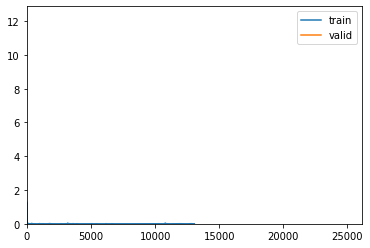

epoch,train_loss,valid_loss,accuracy,time
0,0.000661,12.876712,0.999651,32:09


In [ ]:
experimentIndividual("/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv")